# Lesson 6. Advanced Parameter Estimation

In this Jupyter Notebook more advanced techniques for performing parameter estimation is presented. The following points will be taught in this lesson:
* Selection of least square algorithm
* Adding lower- and upper bounds to parameters in parameter estimation
* Applying multiple random start, to help find the global minimum of the objective function
* Enabling and applying multithreading

The following code block must be run to perform any calculations in this document:

In [1]:
from pythermo import pythermo as pt #Required

import numpy as np #Recommended
from matplotlib import pyplot as plt #Recommended - used for plotting

### Experimental Data Loading
In this project we will once again show examples using the molecule triethylen-glycol (TEG). Pure component data for this molecule is loaded in the following code block.

In [2]:
#Here we initialize the class
exp_data = pt.Experimental_Data()

#By using the "Add" class function, we may add experimental data to the class. First we add vapor pressure data
filename_psat = 'experimental_data/TEG_vapor_pressure.csv'
datatype_psat = 'PSat'
identifier_psat = 'teg_psat'
exp_data.Add(filename_psat, datatype_psat, identifier_psat)

#Similarly, we add liquid density data.
filename_rho = 'experimental_data/TEG_liq_density.csv'
datatype_rho = 'rho'
identifier_rho = 'teg_rho'
exp_data.Add(filename_rho, datatype_rho, identifier_rho)



Furthermore, we would like to impose a temperature interval on the data in the range of 0.4-0.9 Tr.

In [3]:
#It is common to limit the pure component data to a specific temperature range, typically expressed as an
#an interval of reduced temperatures. If we seek to remove data outside these region, we impose the interval by 
#using the ReducedTemperature function

Tr_min = 0.4 #Reduced temperature min
Tr_max = 0.9 #Reduced temperature max
Tc = 769.5 #Critical temprature [K]
exp_data.ReducedTemperature(Tr_min, Tr_max, Tc)

print("After adjusting for reduced temperature")
exp_data.Show_list()

After adjusting for reduced temperature
Data Type        Dim (r x c)     Name           
-------------------------------------------------------------
PSat             38x2            teg_psat       
rho              50x2            teg_rho        




### Loading TEG properties
Critical properties and model parameters for TEG are defined below, they are the same as previous lessons.

In [4]:
crit_props = {
    "Tc" : 769.5,
    "Pc" : 33.2,
    "Om" : 0.05 
}

original_params = {
    "b0" : 128.93,
    "Gamma" : 3622.5,
    "c1" : 0.9100,
    "AssocEng" :  1420.0,
    "AssocVol" : 20.0
}

AssocSch = 24 #Corresponds to 6D associaton scheme

In [5]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pt.Model()

Thermo.NoPureComp(1)
Thermo.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo.CPAParams(1,original_params["b0"],original_params["Gamma"],original_params["c1"])
Thermo.AssocParams(1,AssocSch,original_params["AssocVol"],original_params["AssocEng"])

### Selecting an optimization algorithm
In this section we will learn how to select an optimization algorithm. The PyTherm package supports three optimization algorithms for least square problems:
* Trust Region Reflective
* Dogleg with Rectangular Trust Regions
* Levenberg-Marquardt

In [7]:
#From here we create a Optimizer object
optimizer = pt.Optimizer()

#The optimizer is now given a model to use, the Model object
optimizer.Add_Model(Thermo)

#Now we add the experimental data object to the Optimizer object
optimizer.Add_Experimental_Data(exp_data)

#Now we set the optimization algorithm
algorithm = "trf" # lm - levenberg marquardt, trf - trust region reflective, dogbox - dogleg algorithm
optimizer.Set_Optimization_Algorithm(algorithm)

#Now the optimizer have enough information to perform parameterization. Keep in mind that Optimizer is solely for
#CPA model, a
opti_params = optimizer.Optimization()

In [8]:
print(opti_params)

{'b0': 128.98011009517683, 'Gamma': 3619.2078581514215, 'c1': 1.1761777883654498, 'AssocVol': 16.556632364794833, 'AssocEng': 1342.3205407795367}


### Setting upper and lower bounds for decision variables

In [9]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pt.Model()

Thermo.NoPureComp(1)
Thermo.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo.CPAParams(1,original_params["b0"],original_params["Gamma"],original_params["c1"])
Thermo.AssocParams(1,AssocSch,original_params["AssocVol"],original_params["AssocEng"])

In [14]:
#From here we create a Optimizer object
optimizer = pt.Optimizer()

#The optimizer is now given a model to use, the Model object
optimizer.Add_Model(Thermo)

#Now we add the experimental data object to the Optimizer object
optimizer.Add_Experimental_Data(exp_data)

#Now we set the optimization algorithm (remember, levenberg-marquardt does NOT work with bounds)
algorithm = "trf" # lm - levenberg marquardt, trf - trust region reflective, dogbox - dogleg algorithm
optimizer.Set_Optimization_Algorithm(algorithm)

bounds = {
    "b0" : [125,135],
    "Gamma" : [3000,4000],
    "c1" : [0.5,1.0],
    "AssocVol" : [10,30],
    "AssocEng" : [1000, 2000]
}

optimizer.Add_Bounds(bounds)



#Now the optimizer have enough information to perform parameterization. Keep in mind that Optimizer is solely for
#CPA model, a
opti_params = optimizer.Optimization()

In [15]:
print(opti_params)

{'b0': 129.1844587595801, 'Gamma': 3198.455096771736, 'c1': 0.9999999803629461, 'AssocVol': 15.225681530718825, 'AssocEng': 1841.0940112983033}


### Fixing decision variables

In [16]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pt.Model()

Thermo.NoPureComp(1)
Thermo.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo.CPAParams(1,original_params["b0"],original_params["Gamma"],original_params["c1"])
Thermo.AssocParams(1,AssocSch,original_params["AssocVol"],original_params["AssocEng"])

In [17]:
#From here we create a Optimizer object
optimizer = pt.Optimizer()

#The optimizer is now given a model to use, the Model object
optimizer.Add_Model(Thermo)

#Now we add the experimental data object to the Optimizer object
optimizer.Add_Experimental_Data(exp_data)

#Now we set the optimization algorithm (remember, levenberg-marquardt does NOT work with bounds)
algorithm = "trf" # lm - levenberg marquardt, trf - trust region reflective, dogbox - dogleg algorithm
optimizer.Set_Optimization_Algorithm(algorithm)

fixed = {
    "b0" : True,
    "Gamma" : False,
    "c1" : False,
    "AssocVol" : False,
    "AssocEng" : False
}
optimizer.Fix_Variables(fixed)



#Now the optimizer have enough information to perform parameterization. Keep in mind that Optimizer is solely for
#CPA model, a
opti_params = optimizer.Optimization()

In [18]:
print(opti_params)

{'b0': 128.93, 'Gamma': 3634.5785403211958, 'c1': 1.2160450513788166, 'AssocVol': 16.683441918842224, 'AssocEng': 1279.9272478645348}


### How to use multiple initial conditions for finding global minimum

In [19]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pt.Model()

Thermo.NoPureComp(1)
Thermo.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo.CPAParams(1,original_params["b0"],original_params["Gamma"],original_params["c1"])
Thermo.AssocParams(1,AssocSch,original_params["AssocVol"],original_params["AssocEng"])

In [20]:
#From here we create a Optimizer object
optimizer = pt.Optimizer()

#The optimizer is now given a model to use, the Model object
optimizer.Add_Model(Thermo)

#Now we add the experimental data object to the Optimizer object
optimizer.Add_Experimental_Data(exp_data)

#Now we set the optimization algorithm
algorithm = "trf" # lm - levenberg marquardt, trf - trust region reflective, dogbox - dogleg algorithm
optimizer.Set_Optimization_Algorithm(algorithm)

bounds = {
    "b0" : [125,135],
    "Gamma" : [3000,4000],
    "c1" : [0.5,1.5],
    "AssocVol" : [10,30],
    "AssocEng" : [1000, 2000]
}
iterations = 3
optimizer.Setup_Multistart(bounds, iterations)

opti_params_multistart = optimizer.Optimization(MultiStart = True) 

Iteration 1
Iteration 2
Iteration 3


In [21]:
print(opti_params_multistart)

{'b0': 128.99915737522662, 'Gamma': 4403.538872334299, 'c1': 1.2707814356836287, 'AssocVol': -23.28782280692682, 'AssocEng': -195.4060726525077}


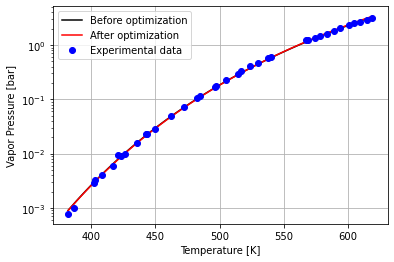

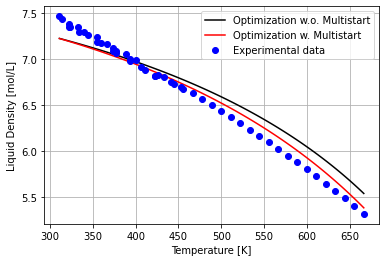

In [22]:
n = 100


exp_psat = exp_data.Retrieve_data('teg_psat')
exp_rho = exp_data.Retrieve_data('teg_rho')

expT_psat = exp_psat[:,0]
expP = exp_psat[:,1]

expT_rho = exp_rho[:,0]
expRho = exp_rho[:,1]

T_model_psat = np.linspace(min(expT_psat),max(expT_psat),n)
T_model_rho = np.linspace(min(expT_rho),max(expT_rho),n)

P_model = np.zeros(n) #Memory allocation - Good practice, more efficient
rho_model = np.zeros(n) #Memory allocation - Good practice, more efficient
P_model_multi = np.zeros(n) #Memory allocation - Good practice, more efficient
rho_model_multi = np.zeros(n) #Memory allocation - Good practice, more efficient


Thermo_improved = pt.Model()
Thermo_improved.NoPureComp(1)
Thermo_improved.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo_improved.CPAParams(1,opti_params["b0"],opti_params["Gamma"],opti_params["c1"])
Thermo_improved.AssocParams(1,AssocSch,opti_params["AssocVol"],opti_params["AssocEng"])

Thermo_improved.Setup_Thermo()

for i in range(0,n):
    P_model[i], b, c = Thermo_improved.PBubble(T_model_psat[i],[1.0])
    rho_model[i] = Thermo.LiqRho(T_model_rho[i],[1.0])


Thermo_improved = pt.Model()
Thermo_improved.NoPureComp(1)
Thermo_improved.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo_improved.CPAParams(1,opti_params_multistart["b0"],opti_params_multistart["Gamma"],opti_params_multistart["c1"])
Thermo_improved.AssocParams(1,AssocSch,opti_params_multistart["AssocVol"],opti_params_multistart["AssocEng"])

Thermo_improved.Setup_Thermo()

for i in range(0,n):
    P_model_multi[i], b, c = Thermo_improved.PBubble(T_model_psat[i],[1.0])
    rho_model_multi[i] = Thermo.LiqRho(T_model_rho[i],[1.0])

Thermo_improved.Finishup_Thermo()
#-----------------------------------------------------------------------------------

plt.plot(T_model_psat,P_model,color="black")
plt.plot(T_model_psat,P_model_multi,color="red")
plt.plot(expT_psat,expP,'o',color="blue",markersize=  6)
plt.xlabel("Temperature [K]")
plt.ylabel("Vapor Pressure [bar]")
plt.yscale('log')

plt.legend(["Before optimization","After optimization","Experimental data"])
plt.grid()
plt.show()

plt.plot(T_model_rho,rho_model,color="black")
plt.plot(T_model_rho,rho_model_multi,color="red")
plt.plot(expT_rho,expRho,'o',color="blue",markersize=  6)
plt.xlabel("Temperature [K]")
plt.ylabel("Liquid Density [mol/L]")
plt.legend(["Optimization w.o. Multistart","Optimization w. Multistart","Experimental data"])
plt.grid()
plt.show()

Implement

- Particle Swarm
- Difference evolution (or differential)

In [23]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pt.Model()

Thermo.NoPureComp(1)
Thermo.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo.CPAParams(1,original_params["b0"],original_params["Gamma"],original_params["c1"])
Thermo.AssocParams(1,AssocSch,original_params["AssocVol"],original_params["AssocEng"])

In [27]:
#From here we create a Optimizer object
optimizer = pt.Optimizer()

#The optimizer is now given a model to use, the Model object
optimizer.Add_Model(Thermo)

#Now we add the experimental data object to the Optimizer object
optimizer.Add_Experimental_Data(exp_data)

bounds = {
    "b0" : [125,135],
    "Gamma" : [3000,4000],
    "c1" : [0.5,1.0],
    "AssocVol" : [10,30],
    "AssocEng" : [1000, 2000]
}
optimizer.Add_Bounds(bounds)


opti_params_pso = optimizer.Particle_Swarm(max_iter = 40, swarm_size = 40)

0 of 40
1 of 40
2 of 40
3 of 40
4 of 40
5 of 40
6 of 40
7 of 40
8 of 40
9 of 40
10 of 40
11 of 40
12 of 40
13 of 40
14 of 40
15 of 40
16 of 40
17 of 40
18 of 40
19 of 40
20 of 40
21 of 40
22 of 40
23 of 40
24 of 40
25 of 40
26 of 40
27 of 40
28 of 40
29 of 40
30 of 40
31 of 40
32 of 40
33 of 40
34 of 40
35 of 40
36 of 40
37 of 40
38 of 40
39 of 40


In [28]:
print(opti_params_pso)

{'b0': 127.1364674311722, 'Gamma': 3673.2780634457854, 'c1': 0.9651690600764034, 'AssocVol': 13.630291168719005, 'AssocEng': 1585.380541769349}


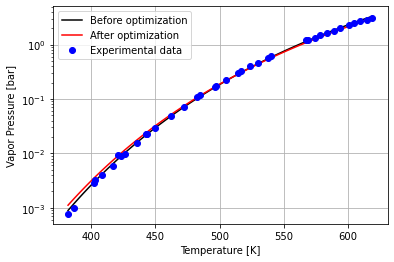

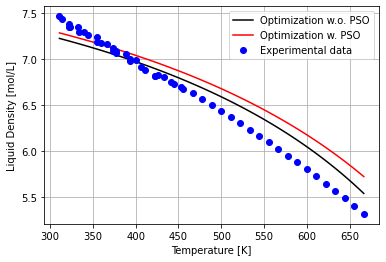

In [29]:
n = 100


exp_psat = exp_data.Retrieve_data('teg_psat')
exp_rho = exp_data.Retrieve_data('teg_rho')

expT_psat = exp_psat[:,0]
expP = exp_psat[:,1]

expT_rho = exp_rho[:,0]
expRho = exp_rho[:,1]

T_model_psat = np.linspace(min(expT_psat),max(expT_psat),n)
T_model_rho = np.linspace(min(expT_rho),max(expT_rho),n)

P_model = np.zeros(n) #Memory allocation - Good practice, more efficient
rho_model = np.zeros(n) #Memory allocation - Good practice, more efficient
P_model_pso = np.zeros(n) #Memory allocation - Good practice, more efficient
rho_model_pso = np.zeros(n) #Memory allocation - Good practice, more efficient


Thermo_improved = pt.Model()
Thermo_improved.NoPureComp(1)
Thermo_improved.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo_improved.CPAParams(1,opti_params["b0"],opti_params["Gamma"],opti_params["c1"])
Thermo_improved.AssocParams(1,AssocSch,opti_params["AssocVol"],opti_params["AssocEng"])

Thermo_improved.Setup_Thermo()

for i in range(0,n):
    P_model[i], b, c = Thermo_improved.PBubble(T_model_psat[i],[1.0])
    rho_model[i] = Thermo.LiqRho(T_model_rho[i],[1.0])


Thermo_improved = pt.Model()
Thermo_improved.NoPureComp(1)
Thermo_improved.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo_improved.CPAParams(1,opti_params_pso["b0"],opti_params_pso["Gamma"],opti_params_pso["c1"])
Thermo_improved.AssocParams(1,AssocSch,opti_params_pso["AssocVol"],opti_params_pso["AssocEng"])

Thermo_improved.Setup_Thermo()

for i in range(0,n):
    P_model_pso[i], b, c = Thermo_improved.PBubble(T_model_psat[i],[1.0])
    rho_model_pso[i] = Thermo.LiqRho(T_model_rho[i],[1.0])

Thermo_improved.Finishup_Thermo()
#-----------------------------------------------------------------------------------

plt.plot(T_model_psat,P_model,color="black")
plt.plot(T_model_psat,P_model_pso,color="red")
plt.plot(expT_psat,expP,'o',color="blue",markersize=  6)
plt.xlabel("Temperature [K]")
plt.ylabel("Vapor Pressure [bar]")
plt.yscale('log')

plt.legend(["Before optimization","After optimization","Experimental data"])
plt.grid()
plt.show()

plt.plot(T_model_rho,rho_model,color="black")
plt.plot(T_model_rho,rho_model_pso,color="red")
plt.plot(expT_rho,expRho,'o',color="blue",markersize=  6)
plt.xlabel("Temperature [K]")
plt.ylabel("Liquid Density [mol/L]")
plt.legend(["Optimization w.o. PSO","Optimization w. PSO","Experimental data"])
plt.grid()
plt.show()

In [43]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pt.Model()

Thermo.NoPureComp(1)
Thermo.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo.CPAParams(1,original_params["b0"],original_params["Gamma"],original_params["c1"])
Thermo.AssocParams(1,AssocSch,original_params["AssocVol"],original_params["AssocEng"])

#From here we create a Optimizer object
optimizer = pt.Optimizer()

#The optimizer is now given a model to use, the Model object
optimizer.Add_Model(Thermo)

#Now we add the experimental data object to the Optimizer object
optimizer.Add_Experimental_Data(exp_data)

bounds = {
    "b0" : [125,135],
    "Gamma" : [3000,4000],
    "c1" : [0.5,1.0],
    "AssocVol" : [10,30],
    "AssocEng" : [1000, 2000]
}
optimizer.Add_Bounds(bounds)


opti_params_pso = optimizer.Particle_Swarm(max_iter = 300, swarm_size = 50)

opti_params_nm = optimizer.Nelder_Mead()

0 of 300
1 of 300
2 of 300
3 of 300
4 of 300
5 of 300
6 of 300
7 of 300
8 of 300
9 of 300
10 of 300
11 of 300
12 of 300
13 of 300
14 of 300
15 of 300
16 of 300
17 of 300
18 of 300
19 of 300
20 of 300
21 of 300
22 of 300
23 of 300
24 of 300
25 of 300
26 of 300
27 of 300
28 of 300
29 of 300
30 of 300
31 of 300
32 of 300
33 of 300
34 of 300
35 of 300
36 of 300
37 of 300
38 of 300
39 of 300
40 of 300
41 of 300
42 of 300
43 of 300
44 of 300
45 of 300
46 of 300
47 of 300
48 of 300
49 of 300
50 of 300
51 of 300
52 of 300
53 of 300
54 of 300
55 of 300
56 of 300
57 of 300
58 of 300
59 of 300
60 of 300
61 of 300
62 of 300
63 of 300
64 of 300
65 of 300
66 of 300
67 of 300
68 of 300
69 of 300
70 of 300
71 of 300
72 of 300
73 of 300
74 of 300
75 of 300
76 of 300
77 of 300
78 of 300
79 of 300
80 of 300
81 of 300
82 of 300
83 of 300
84 of 300
85 of 300
86 of 300
87 of 300
88 of 300
89 of 300
90 of 300
91 of 300
92 of 300
93 of 300
94 of 300
95 of 300
96 of 300
97 of 300
98 of 300
99 of 300
100 of 300

In [44]:
print(opti_params)
print(opti_params_pso)
print(opti_params_nm)

{'b0': 128.93, 'Gamma': 3634.5785403211958, 'c1': 1.2160450513788166, 'AssocVol': 16.683441918842224, 'AssocEng': 1279.9272478645348}
{'b0': 129.36850961199352, 'Gamma': 3345.660610764927, 'c1': 0.9993711299510619, 'AssocVol': 10.032960073519954, 'AssocEng': 1926.2443849041936}
{'b0': 129.3748626046826, 'Gamma': 3345.6314180147465, 'c1': 0.9999999096789182, 'AssocVol': 10.059390263969814, 'AssocEng': 1926.2463834104158}


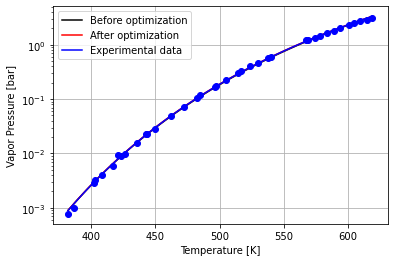

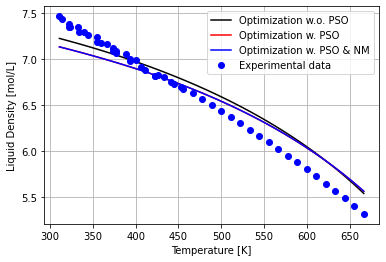

In [45]:
n = 100


exp_psat = exp_data.Retrieve_data('teg_psat')
exp_rho = exp_data.Retrieve_data('teg_rho')

expT_psat = exp_psat[:,0]
expP = exp_psat[:,1]

expT_rho = exp_rho[:,0]
expRho = exp_rho[:,1]

T_model_psat = np.linspace(min(expT_psat),max(expT_psat),n)
T_model_rho = np.linspace(min(expT_rho),max(expT_rho),n)

P_model = np.zeros(n) #Memory allocation - Good practice, more efficient
rho_model = np.zeros(n) #Memory allocation - Good practice, more efficient
P_model_pso = np.zeros(n) #Memory allocation - Good practice, more efficient
rho_model_pso = np.zeros(n) #Memory allocation - Good practice, more efficient
P_model_nm = np.zeros(n) #Memory allocation - Good practice, more efficient
rho_model_nm = np.zeros(n) #Memory allocation - Good practice, more efficient


Thermo_improved = pt.Model()
Thermo_improved.NoPureComp(1)
Thermo_improved.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo_improved.CPAParams(1,opti_params["b0"],opti_params["Gamma"],opti_params["c1"])
Thermo_improved.AssocParams(1,AssocSch,opti_params["AssocVol"],opti_params["AssocEng"])

Thermo_improved.Setup_Thermo()

for i in range(0,n):
    P_model[i], b, c = Thermo_improved.PBubble(T_model_psat[i],[1.0])
    rho_model[i] = Thermo.LiqRho(T_model_rho[i],[1.0])
    
Thermo_improved.Finishup_Thermo()

Thermo_improved = pt.Model()
Thermo_improved.NoPureComp(1)
Thermo_improved.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo_improved.CPAParams(1,opti_params_pso["b0"],opti_params_pso["Gamma"],opti_params_pso["c1"])
Thermo_improved.AssocParams(1,AssocSch,opti_params_pso["AssocVol"],opti_params_pso["AssocEng"])

Thermo_improved.Setup_Thermo()

for i in range(0,n):
    P_model_pso[i], b, c = Thermo_improved.PBubble(T_model_psat[i],[1.0])
    rho_model_pso[i] = Thermo.LiqRho(T_model_rho[i],[1.0])

Thermo_improved.Finishup_Thermo()

Thermo_improved = pt.Model()
Thermo_improved.NoPureComp(1)
Thermo_improved.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo_improved.CPAParams(1,opti_params_nm["b0"],opti_params_nm["Gamma"],opti_params_nm["c1"])
Thermo_improved.AssocParams(1,AssocSch,opti_params_nm["AssocVol"],opti_params_nm["AssocEng"])

Thermo_improved.Setup_Thermo()

for i in range(0,n):
    P_model_nm[i], b, c = Thermo_improved.PBubble(T_model_psat[i],[1.0])
    rho_model_nm[i] = Thermo.LiqRho(T_model_rho[i],[1.0])

Thermo_improved.Finishup_Thermo()
#-----------------------------------------------------------------------------------

plt.plot(T_model_psat,P_model,color="black")
plt.plot(T_model_psat,P_model_pso,color="red")
plt.plot(T_model_psat,P_model_nm,color="blue")
plt.plot(expT_psat,expP,'o',color="blue",markersize=  6)
plt.xlabel("Temperature [K]")
plt.ylabel("Vapor Pressure [bar]")
plt.yscale('log')

plt.legend(["Before optimization","After optimization","Experimental data"])
plt.grid()
plt.show()

plt.plot(T_model_rho,rho_model,color="black")
plt.plot(T_model_rho,rho_model_pso,color="red")
plt.plot(T_model_rho,rho_model_nm,color="blue")
plt.plot(expT_rho,expRho,'o',color="blue",markersize=  6)
plt.xlabel("Temperature [K]")
plt.ylabel("Liquid Density [mol/L]")
plt.legend(["Optimization w.o. PSO","Optimization w. PSO","Optimization w. PSO & NM","Experimental data"])
plt.grid()
plt.show()